# Lagrangian Tracker for Air Pollution
### Here we present the functions used for some of the diagnostics performed in the doi: paper. 
### Notice that the function named: lagrangian is the one that follow and calculate the objects.
## Please cite as: 
#### Casallas A., Cabrera A., Guevara-Luna M.A., Tompkins A., Gonzalez Y., Aranda J., Belalcázar L.C., Mogollon-Sotelo C., Celis N., Lopez-Barrera E.A., Peña-Rincon C.A., Ferro C., pre-print. Air Pollution Analysis in Northwestern South America: A New Lagrangian Framework. Science of the Total Environment. 

In [1]:
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pylab import *
import seaborn as sns
import pdb
import datetime as dt
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage.measurements import center_of_mass, label
from skimage.feature import peak_local_max
from skimage.segmentation import active_contour,watershed
import pyproj
import math
import scipy.stats as sci
import xskillscore as xs

<ipython-input-1-ef9855459774>:13: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass, label
<ipython-input-1-ef9855459774>:13: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass, label


### Lagrangian function

In [2]:
def lagrangian(path,constant,data,var,thr,fp,ini,end,pcen):
    #Start label file so that we do not fuck up the initial one
    obj = xr.DataArray(data*constant,coords=data.coords,attrs=data.attrs,name=var)
    ### Starting with distances and so on
    all_obj = np.where(obj>thr,1,0)
    distance = ndi.distance_transform_edt(all_obj)
    ### This next line is very important, is the one that selects the location of the centers
    ### Tests should be made to found the best centers depending on the desire size of objects
    peaks = peak_local_max(np.array(distance),  footprint = np.ones((fp,fp,fp)), labels = np.array(all_obj))
    ### The next commented lines are for python 3.6 and refine the temporal tracking
    ### The script can be use with precision without these following lines
    #is_peak = peak_local_max(np.array(distance), indices=False, footprint=np.ones((1, 1, 1)))
    #tmp_labels = label(is_peak)[0]
    #merged_peaks = center_of_mass(is_peak, tmp_labels, range(1, np.max(tmp_labels)+1))
    coords = np.array(peaks).astype(int)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance,markers,mask=all_obj,watershed_line=True)
    obj['Objects'] = (['time','latitude','longitude'],labels)
    obj.to_netcdf(path+'labels_'+ini+'-'+end+'_'+var+'_'+str(pcen)+'_'+str(fp)+'.nc')
    return(obj)

In [3]:
### Select the period to study
ini = '2014-01-01'
end = '2021-12-31'
### Indicate the names of the variables you are interesting in and also the name of the files
varis1 = ['pm2p5','pm10','go3','so2']
files = ['PM2p5_all.nc','PM10_all.nc','ozone_ug_m3.nc','SO2_ug_m3.nc']
### Indicate the path of the raw data and also the path in which you want to save the data
path_obj = 'Datos_CAMS/Objects_Data/'
path_data = 'Datos_CAMS/Datos_contaminantes/'
### In CAMS the units are not in ug_m3 so you need to convert it
### In the case of O3 and SO2 an extra step is needed, and is describe here: 
### https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710, then the constant is ready to be use
constant = 1e9 
### Directory to save the output
data = {}
### This needs to be change depending the need of the user. 
### The smaller the segments are, the smaller the objects, so more objects are expected. 
### A randomized search is normally needed to identify the best footprint
footprint = 10
### The percentiles are the thresholds!
percens = [90,90,70,90]
for i,var in enumerate(varis1):
    print('Starting with: '+var)
    ### The try is to avoid creating the objects every time!
    try:
        obj = xr.open_dataset(path_obj+'labels_'+ini+'-'+end+'_'+var+'_'+str(percens[i])+'_'+str(footprint)+'.nc')
        print('File ready!')
        data[var] = obj
    except:
        print('File not ready, so lets create it')
        data = xr.open_dataset(path_data+files[i])
        data = data[var].loc[ini:end]
        thr = np.percentile(data,percens[i])*constant
        obj = lagrangian(path_obj,constant,data,var,thr,footprint,ini,end,percens[i])
        data[var] = obj

Starting with: pm2p5
File ready!
Starting with: pm10
File ready!
Starting with: go3
File ready!
Starting with: so2
File ready!


### Calculate the distance of the objects and the angle between the city and the onset of the polluted events

In [4]:
def distance_coords(lon_eve, lat_eve, lon_cit, lat_cit):
    ## We calculate here the distance between the city and the location 
    ## where the high polluted event starts
    ## It is important to identify the longitude and latitude of the event onset and the cities
    geodesic = pyproj.Geod(ellps='WGS84')
    angle,_,distance = geodesic.inv(lon_eve, lat_eve, lon_cit, lat_cit)
    return(angle,distance/1000)

def calcBearing(long1, lat1, long2, lat2):
    ## Another easier way to calculate the angles
    ## We need the longitude and latitude of the event onset and the cities
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    bearing = math.atan2(x,y)   # use atan2 to determine the quadrant
    bearing = math.degrees(bearing)
    return(bearing)

def calcNSEW(long1, lat1, long2, lat2):
    ## Identify the coordinate of each angle
    ## We need the longitude and latitude of the event onset and the cities
    points = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    bearing = calcBearing(long1, lat1, long2, lat2)
    bearing += 22.5
    bearing = bearing % 360
    bearing = int(bearing / 45) # values 0 to 7
    NSEW = points[bearing]
    return(NSEW)

def count_per_cardinal_point(angles,cardinal):
    ## Counting each cardinal point! and cardinal is:
    ## e.g., cardinal = ['N','NE','E','SE','S','SW','W','NW']
    num = []
    tmp = np.array(angles) 
    for i,card in enumerate(cardinal):
        num.append(len(tmp[tmp==card]))
    return(num)

## Some useful functions to calculate other diagnostics

In [5]:
def create_empty_xr(ds):
    ### Create and xarrar similar to the one we already have, from the lagrangian or from CAMS
    return xr.zeros_like(ds)
    
def find_closest(df, lat, lon): 
    ### Here we calculate the closest point to lon,lat point selected from a MODIS file
    dist = (df['latitude'] - lat).abs() + (df['longitude'] - lon).abs()
    return df.loc[dist.idxmin()]

def count_hotspots(ds,fechas,lat,lon):
    ### This function serve to create a Hotspots netcdf file by counting the number of hotspots per pixel
    ### The pixels are the same as the ones input in create empty xr, so they need to be the same as CAMS
    ### or the same as the lagrangian, since the idea is to then operate both, meaning they have to be in
    ### in the same grid
    nc_data = ds.copy()
    nc_data  = nc_data.groupby(nc_data.time.dt.strftime('%Y-%m-%d')).mean()
    nc_data['strftime'] = pd.to_datetime(nc_data.strftime.values)
    borrar_dataframe = nc_data.to_dataframe()
    borrar_dataframe = borrar_dataframe.reset_index(level=[0,1]).reset_index()
    for i,fecha in enumerate(fechas):
        print('Number: '+str(i)+' of '+str(len(fechas)))
        cor_cerca = find_closest(borrar_dataframe,lat[i],lon[i])
        valor = borrar_dataframe[(borrar_dataframe['strftime'] == fecha) & 
                                 (borrar_dataframe['latitude'] == cor_cerca.latitude) & 
                                 (borrar_dataframe['longitude'] == cor_cerca.longitude)]
        ### Change pm2p5 if needed
        borrar_dataframe.loc[valor.index,'pm2p5'] += 1
    
    borrar_dataframe = borrar_dataframe.rename({'strftime':'time'},axis = 1)
    ### Change pm2p5 or Hotspots if needed or desire
    borrar_dataframe = borrar_dataframe.rename({'pm2p5':'Hotspots'},axis = 1)
    ds = borrar_dataframe.set_index(['time', 'latitude', 'longitude']).to_xarray()
    ds.to_netcdf('Hotspots_count.nc')
    return ds

####### If the user wants to calculate the spatial correlation between fires and pollution plumes
### https://xskillscore.readthedocs.io/en/stable/quick-start.html
#tmp = xs.spearman_r(sea_dict[var+'_'+time][var],sea_dict['Hotspots_'+time],dim='time')
#tmp_s = xs.spearman_r_p_value(sea_dict[var+'_'+time][var],sea_dict['Hotspots_'+time],dim='time')
### where seas_dict have the plumes from the lagrangian and the hotspots, all split depending the season

# From here on we are simply showing and example, but the functions and small example above is what is needed to produce the objects, and some of the diagnostics, which is the important element of this script. The following example helps in the implementation of the function.

In [6]:
def errors_out(var):
    #Take out errors for 0 values and the error indicator 9999
    df = pd.read_csv('Hour_mean_data/'+var+'_hourmean.csv', parse_dates=True, index_col=0)
    df.replace(0,np.nan, inplace=True)
    df.replace(9999.,np.nan, inplace=True)
    return(df)

def polluted_dates(df,pc,ini_d,end_d,lag,ini,mit,fin,sea):
    #Identify the polluted days for each pollutant depending on a percentile, and dates
    dates = {}
    daily = df.resample('D').mean()
    daily = daily.loc[ini_d:end_d]
    pcen = daily.where(daily>daily.quantile(pc))
    for col in pcen.columns:
        if sea == 'DJF' or sea == 'MAM' or sea == 'JJA' or sea == 'SON':
            tmp_date = pcen[col][pcen[col].index.month.isin([ini,mit,fin])]
        else:
            tmp_date = pcen[col]
        dates[col] = (tmp_date.dropna().index + pd.Timedelta(days=float(lag))).strftime('%Y-%m-%d').values
    return(dates)

def ang_mat(varis,city,seas,ang_pos):
    #This function creates a matrix for the angles, depending on the seasons
    mat = np.ones((5,8))
    for var in varis:
        for i,sea in enumerate(seas):
            name = var+'_'+sea+'_'+city
            mat[i,:] = np.array(ang_pos[name])
    return(mat)

########## Create different dictionary types ##########
def dictionary_list(varis,cities,seas):
    datasets = {}
    for var in varis:
        for city in cities:
            for sea in seas:
                name = var+'_'+sea+'_'+city
                datasets[name] = []
    return(datasets)

def dictionary_mat(varis,cities,seas,arrival):
    datasets = {}
    for var in varis:
        for city in cities:
            for sea in seas:
                name = var+'_'+sea+'_'+city
                datasets[name] = np.ones((250,len(arrival[name])))*np.nan
    return(datasets)

def dictionary_array(varis,cities,seas):
    datasets = {}
    for var in varis:
        for city in cities:
            for sea in seas:
                name = var+'_'+sea+'_'+city
                datasets[name] = np.array([])
    return(datasets)

In [7]:
def objects_per_city(data,var,date_file,city,lon,lat,spa_thr,tim_thr,lag):
    # This function would select the objects that "touch" the location selected. 
    # It will save the object numbers in an array, which could be then save in a dictionary
    # Notice that there is a threshold, since we care only on large events, so we filtered
    # The ones that produce locally. We also filter the events that last less than tim_thr hours.
    # The function also save the arrival date of the event to the city!
    # It would be nice to do it for all the cities at once, but all the coordinates are needed
    objetos = np.array([])
    arrival_date = np.array([])
    for i,dates in enumerate(date_file[city]):
        tmp_date = dt.datetime.strptime(dates, '%Y-%m-%d')
        sta = (tmp_date - dt.timedelta(days=lag)).strftime('%Y-%m-%d')
        end = (tmp_date + dt.timedelta(days=lag)).strftime('%Y-%m-%d')
        one_event = data[var][var].loc[sta:end]
        #First lets select the objects that arrive to the city!
        tmp_data = one_event.Objects.sel(latitude=lat,longitude=lon, method = 'nearest')
        #Tag the unique values!
        tags = np.unique(np.array(tmp_data.where(tmp_data>0)))[0:-1] #nan appear at the end so lets remove it
        # We only care about big plumes, so lets remove the small ones
        for tag in tags:
            size = one_event.Objects.where(one_event.Objects==int(tag)).count().values
            if size > spa_thr:
                varia = data[var][var].where(data[var].Objects==int(tag)).mean(dim=['latitude','longitude'])
                y = varia.dropna(dim='time')
                if len(y) > tim_thr:
                    objetos = np.append(objetos,tag)
    objetos = np.unique(objetos)
    for tag in objetos:
        varia = data[var].Objects.sel(latitude=lat,longitude=lon, method = 'nearest')
        varia = varia.where(varia == int(tag))
        y = varia.dropna(dim='time').time.dt.strftime('%Y-%m-%d %H:%M:%S')[0].values
        arrival_date = np.unique(np.append(arrival_date,y))
    return(objetos, arrival_date)

In [8]:
#Process data
pols = ['PM25']#PM25,PM10,'O3','SO2']
dfs = {}
varis = ['pm2p5']#pm2p5 pm10 so2 go3
for i,pol in enumerate(pols):
    dfs[varis[i]] = errors_out(pol)
    
#Identify polluted dates per pollutant and per city e.g., dates['PM10']['Bogota'] would show
# the dates of Bogota depending on the PM10
date_no_lag = {}
pcen = [0.9]
ini_d = '2014-01-01'
end_d = '2021-12-31'
ini = [0,12,3,6,9]
mit = [0,1,4,7,10]
fin = [0,2,5,8,11]
seas = ['all','DJF','MAM','JJA','SON']
lags = [0]

for i,var in enumerate(varis):
        for lag in lags:
            for j,sea in enumerate(seas):
                date_no_lag[var+'_'+sea] = polluted_dates(dfs[var],pcen[i],ini_d,end_d,
                                                          lag,ini[j],mit[j],fin[j],sea)

In [9]:
### We determine here the number of the objects and also the date of arrival of each of them to the city
### We have some thresholds, we can change them, but are selected to be sure we are focusing on a big
### Long-lasting event! That should be associated to wildfires.
spa_thr = 5 #10
tim_thr = 6 #12
objetos = {}
arrival = {}
if varis[0] == 'pm2p5' or varis[0] == 'go3':
    cities = ['Bogota', 'Medellin', 'Cali']
    lats = [4.66,6.25,3.43]
    lons = [-74.08,-75.56,-76.52]
elif varis[0] == 'so2':
    cities = ['Bogota','Cali'] #Bogota Medellin Cali
    lats = [4.66,3.43] # 4.66,6.25,3.43
    lons = [-74.08,-76.52] # -74.08,-75.56,-76.52
laggi = 0

for var in varis:
    for sea in seas:
        for i,city in enumerate(cities):
            name = var+'_'+sea+'_'+city
            print(name+' variable!')
            objetos[name], arrival[name] = objects_per_city(data,var,date_no_lag[var+'_'+sea],city,
                                                            lons[i],lats[i],spa_thr,tim_thr,laggi)

pm2p5_all_Bogota variable!
pm2p5_all_Medellin variable!
pm2p5_all_Cali variable!
pm2p5_DJF_Bogota variable!
pm2p5_DJF_Medellin variable!
pm2p5_DJF_Cali variable!
pm2p5_MAM_Bogota variable!
pm2p5_MAM_Medellin variable!
pm2p5_MAM_Cali variable!
pm2p5_JJA_Bogota variable!
pm2p5_JJA_Medellin variable!
pm2p5_JJA_Cali variable!
pm2p5_SON_Bogota variable!
pm2p5_SON_Medellin variable!
pm2p5_SON_Cali variable!


In [10]:
### Here we save the spatial mean of the events into a file. 
### We also save the complete events to then calculate the lat and lon coordinate of its initiation.

datasets = dictionary_list(varis,cities,seas)
dat_lats = dictionary_array(varis,cities,seas)
dat_lons = dictionary_array(varis,cities,seas)

for var in varis:
    for i,city in enumerate(cities):
        for j,sea in enumerate(seas):
            name = var+'_'+sea+'_'+city
            for objec in objetos[name]:
                varia = data[var][var].where(data[var].Objects==int(objec))
                evemean = varia.mean(dim=['latitude','longitude']).dropna(dim='time')
                datasets[name].append(evemean)
                tmp_data = varia.loc[evemean.time.dt.strftime('%Y-%m-%d %H:%M:%S')[0].values]
                tmp_obj = tmp_data.Objects.where(tmp_data.Objects == int(objec), drop=True)
                dat_lats[name] = np.append(dat_lats[name], tmp_obj.latitude.mean().values)
                dat_lons[name] = np.append(dat_lons[name], tmp_obj.longitude.mean().values)
                
## As we already have the longitudes and latitudes, we can try to calculate the distance and the angle from
## The starting point of the event to the city of interest
distances = dictionary_list(varis,cities,seas)
angles = dictionary_list(varis,cities,seas)

for var in varis:
    for i,city in enumerate(cities):
        for sea in seas:
            name = var+'_'+sea+'_'+city
            for j,lat_eve in enumerate(dat_lats[name]):
                lon_eve = dat_lons[name][j]
                angl,dist = distance_coords(lons[i], lats[i], lon_eve, lat_eve)
                distances[name].append(dist)
                angl1 = calcNSEW(lons[i], lats[i], lon_eve, lat_eve)
                angles[name].append(angl1)

In [11]:
cardinal = ['N','NE','E','SE','S','SW','W','NW']
ang_pos_count = {}
for var in varis:
    for city in cities:
        for sea in seas:
            name = var+'_'+sea+'_'+city
            ang_pos_count[name] = count_per_cardinal_point(angles[name],cardinal)
            
bog_mat = ang_mat(varis,'Bogota',seas,ang_pos_count)
med_mat = ang_mat(varis,'Medellin',seas,ang_pos_count)
cal_mat = ang_mat(varis,'Cali',seas,ang_pos_count)

dist_mat = np.ones((3,5))
for var in varis:
    for i,city in enumerate(cities):
        for j,sea in enumerate(seas):
            name = var+'_'+sea+'_'+city
            dist_mat[i,j] = np.mean(distances[name])

Text(0.0, 1.0, '(d)')

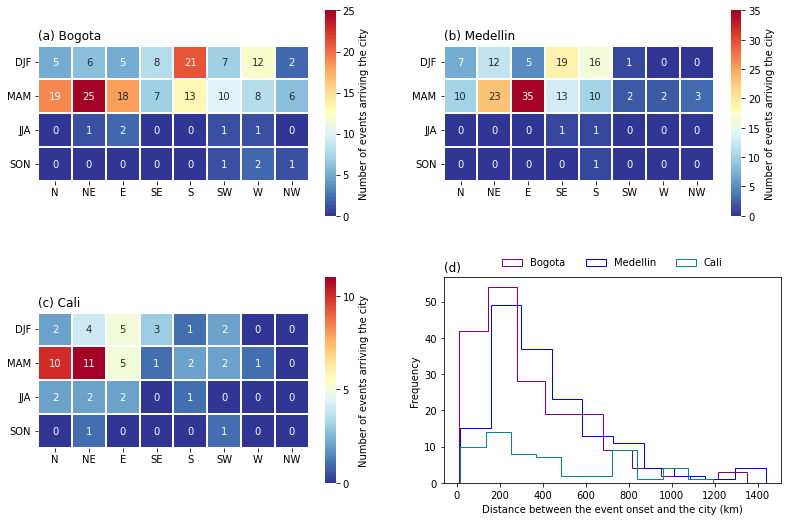

In [12]:
### Heatmap of angles
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2,left = 0.09, right = 0.95, hspace=0.3, wspace=0.2, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])
sns.heatmap(bog_mat[1:,:],square=True, annot=True, linewidth = 2, cmap = 'RdYlBu_r', fmt='g',
            yticklabels=['DJF','MAM','JJA','SON'], xticklabels=cardinal,
            cbar_kws={'label': 'Number of events arriving the city', "ticks": np.arange(0,75.1,5)})
plt.yticks(rotation=0)
plt.title('(a) Bogota', loc = 'left')

ax = plt.subplot(gs[1])
ax = sns.heatmap(med_mat[1:,:],square=True, annot=True, linewidth = 2, cmap = 'RdYlBu_r', fmt='g',
                 yticklabels=['DJF','MAM','JJA','SON'], xticklabels=cardinal,
                 cbar_kws={'label': 'Number of events arriving the city', "ticks": np.arange(0,35.1,5)})
plt.yticks(rotation=0)
plt.title('(b) Medellin', loc = 'left')

ax = plt.subplot(gs[2])
ax = sns.heatmap(cal_mat[1:,:],square=True, annot=True, linewidth = 2, cmap = 'RdYlBu_r', fmt='g',
                 yticklabels=['DJF','MAM','JJA','SON'], xticklabels=cardinal,
                 cbar_kws={'label': 'Number of events arriving the city', "ticks": np.arange(0,50.1,5)})
plt.yticks(rotation=0)
plt.title('(c) Cali', loc = 'left')

ax = plt.subplot(gs[3])
if varis[0] == 'pm2p5' or varis[0] == 'go3':
    colors = ['purple','blue','darkcyan']
elif varis[0] == 'so2':
    colors = ['purple','darkcyan']

for var in varis:
    for i,city in enumerate(cities):
        plt.hist(np.array(distances[var+'_all_'+city]), histtype='step', color = colors[i], label = city)
plt.legend(frameon = False, ncol = 3, loc = 'upper center', bbox_to_anchor = (0.5,1.14))
plt.ylabel('Frequency')
plt.xlabel('Distance between the event onset and the city (km)')
plt.title('(d)', loc = 'left')

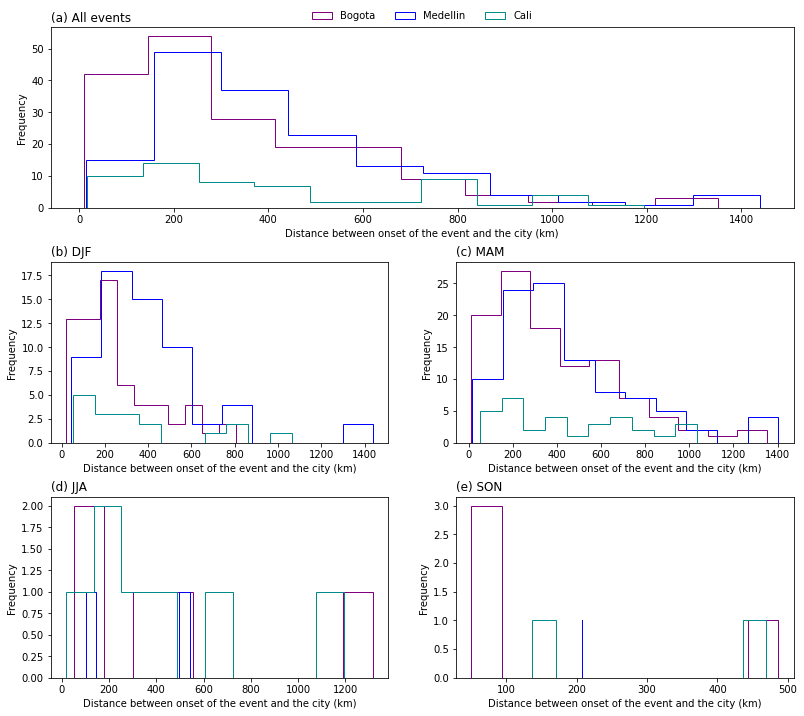

In [13]:
fig = plt.figure(figsize=(12,15))
gs = GridSpec(4,2,left = 0.09, right = 0.95, hspace=0.3, wspace=0.2, top = 0.9, bottom = 0.08)
if varis[0] == 'pm2p5' or varis[0] == 'go3':
    colors = ['purple','blue','darkcyan']
elif varis[0] == 'so2':
    colors = ['purple','darkcyan']
ax = plt.subplot(gs[0,:])
for var in varis:
    for i,city in enumerate(cities):
        plt.hist(np.array(distances[var+'_all_'+city]), histtype='step', color = colors[i], label = city)
plt.legend(frameon = False, ncol = 3, loc = 'upper center', bbox_to_anchor = (0.5,1.14))
plt.ylabel('Frequency')
plt.xlabel('Distance between onset of the event and the city (km)')
plt.title('(a) All events', loc = 'left')

title = ['(b)','(c)','(d)','(e)']
seas1 = ['DJF','MAM','JJA','SON']
for var in varis:
    for i,sea in enumerate(seas1):
        ax = plt.subplot(gs[i+2])
        for j,city in enumerate(cities):
            plot = np.array(distances[var+'_'+sea+'_'+city])
            plt.hist(plot, histtype='step', color = colors[j], label = city)
        plt.ylabel('Frequency')
        plt.xlabel('Distance between onset of the event and the city (km)')
        plt.title(title[i]+' '+sea, loc = 'left')

## Composites!, 0 (cero) indicates the arrival time! here we calculate and plot them

In [14]:
### Here we create the composites. The center of the composites is the arrival time to the selected city
composites = dictionary_mat(varis,cities,seas,arrival)

for var in varis:
    for city in cities:
        for sea in seas:
            name = var+'_'+sea+'_'+city
            med = int(np.shape(composites[name])[0]/2)
            for i,date in enumerate(arrival[name]):
                try:
                    posi = np.argwhere(np.array(datasets[name][i] == datasets[name][i].loc[date]))[0][0]              
                    composites[name][med-posi:med-posi+len(datasets[name][i]),i] = np.array(datasets[name][i])
                except:
                    #This appears when no data is available in the stations
                    print('No Dataset')

No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset
No Dataset


<ipython-input-15-0b6fe720e7e3>:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(composites[varis[0]+'_all_'+city],axis=1)
/opt/homebrew/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-15-0b6fe720e7e3>:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(composites[varis[0]+'_all_'+city],axis=1)
/opt/homebrew/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-15-0b6fe720e7e3>:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(composites[varis[0]+'_all_'+city],axis=1)
/opt/homebrew/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-15-0b6fe720e7e3>:41: Runt

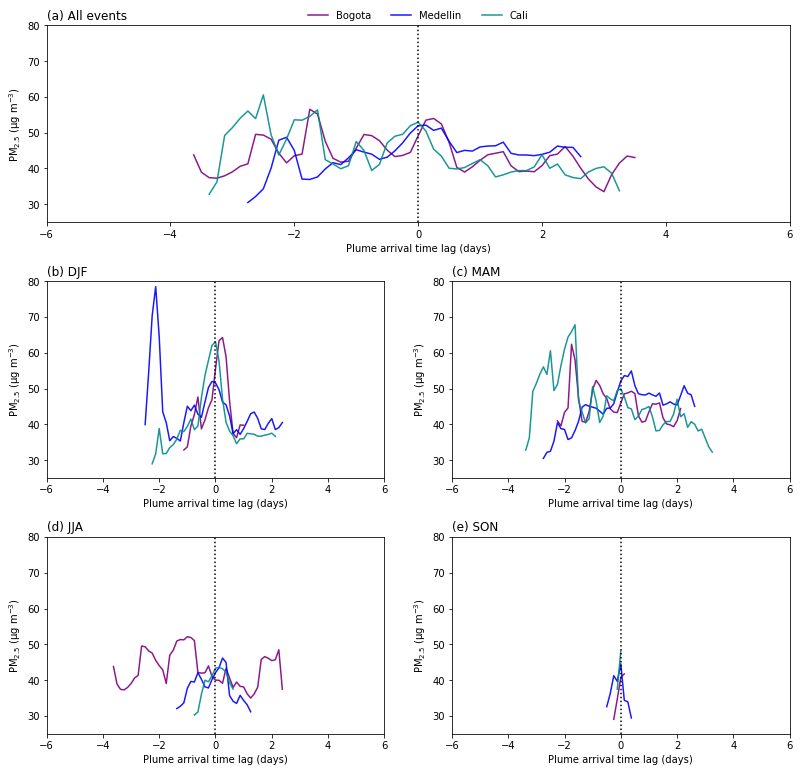

In [15]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(3,2,left = 0.09, right = 0.95, hspace=0.3, wspace=0.2, top = 0.9, bottom = 0.08)
if varis[0] == 'pm2p5' or varis[0] == 'go3':
    colors = ['purple','blue','darkcyan']
elif varis[0] == 'so2':
    colors = ['purple','darkcyan']
ax = plt.subplot(gs[0,:])
for i,city in enumerate(cities):
    mean = np.nanmean(composites[varis[0]+'_all_'+city],axis=1)
    std = np.nanstd(composites[varis[0]+'_all_'+city],axis=1)
    initial = np.argwhere(np.isnan(mean) == False)[0][0]
    mean = mean[initial:med+np.abs(initial-med)]
    std = std[initial:med+np.abs(initial-med)]
    x = np.arange((initial-med)/8,(np.abs(initial-med))/8,1/8)
    plt.plot(x,mean, color = colors[i], label = city, alpha = 0.9)
    #plt.plot(x,mean-std, color = colors[i], linestyle=':', linewidth = 0.5)
    #plt.plot(x,mean+std, color = colors[i], linestyle=':', linewidth = 0.5)
    #plt.fill_between(x, mean + std, mean - std, color = colors[i], alpha = 0.05)
plt.axvline(0, color = 'k', linestyle = ':')
if varis[0] == 'pm2p5':
    plt.ylim(25,80)
    plt.xlim(-6,6)
    plt.ylabel('PM$_{2.5}$ (μg m$^{-3}$)')
elif varis[0] == 'so2':
    plt.ylim(0,6.5)
    plt.xlim(-5,5)
    plt.ylabel('SO$_{2}$ (μg m$^{-3}$)')
elif varis[0] == 'go3':
    plt.ylim(40,75)
    plt.xlim(-15,15)
    plt.ylabel('O$_{3}$ (μg m$^{-3}$)')
plt.xlabel('Plume arrival time lag (days)')
plt.title('(a) All events', loc = 'left')
plt.legend(frameon = False, ncol = 3, loc = 'upper center', bbox_to_anchor = (0.5,1.12))

title = ['(b)','(c)','(d)','(e)']
seas1 = ['DJF','MAM','JJA','SON']
for i,sea in enumerate(seas1):
    ax = plt.subplot(gs[i+2])
    for j,city in enumerate(cities):
        mean = np.nanmean(composites[varis[0]+'_'+sea+'_'+city],axis=1)
        std = np.nanstd(composites[varis[0]+'_'+sea+'_'+city],axis=1)
        try:
            initial = np.argwhere(np.isnan(mean) == False)[0][0]
            mean = mean[initial:med+np.abs(initial-med)]
            std = std[initial:med+np.abs(initial-med)]
            mean[mean>150] = 78
            mean[mean>80] = 75
            x = np.arange((initial-med)/8,(np.abs(initial-med))/8,1/8)
            plt.plot(x,mean, color = colors[j], label = city, alpha = 0.9)
        except:
            print('No events!')
    plt.axvline(0, color = 'k', linestyle = ':')
    if varis[0] == 'pm2p5':
        plt.ylim(25,80)
        plt.xlim(-6,6)
        plt.ylabel('PM$_{2.5}$ (μg m$^{-3}$)')
    elif varis[0] == 'so2':
        plt.ylim(0,6.5)
        plt.xlim(-5,5)
        plt.ylabel('SO$_{2}$ (μg m$^{-3}$)')
    elif varis[0] == 'go3':
        plt.ylim(40,75)
        plt.xlim(-15,15)
        plt.ylabel('O$_{3}$ (μg m$^{-3}$)')
    
    plt.xlabel('Plume arrival time lag (days)')
    plt.title(title[i]+' '+sea, loc = 'left')